<a href="https://colab.research.google.com/github/AJAkil/All-things-AI/blob/master/GNN_intro_ptgeo_official_guide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Intro to PyG

In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

1.13.1+cu116
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print(f'=====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}') #feature dim of each node
print(f'Number of classes: {dataset.num_classes}') # labels


Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [ ]:
print(type(dataset[0]))

<class 'torch_geometric.data.data.Data'>


In [ ]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


The graph is presented as a whole. There are some nodes for which we know the labels and our task is to infer the labels of other nodes. We can view this from the train mask, which shoes True for the nodes for which we have the training labels. 

In [ ]:
data.train_mask

tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])

Edge information are saved in COO ( coordinate format ) which only stores information for existing edges in the adjacency matrix of the graph

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = data.edge_index
print(edge_index.t())

<IPython.core.display.Javascript object>

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

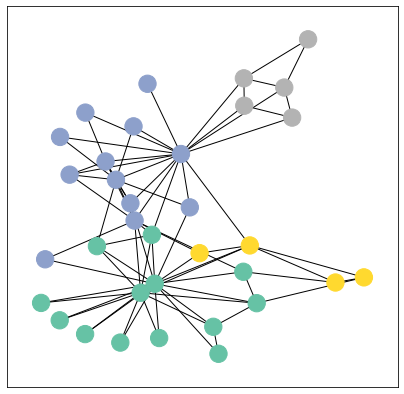

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(1234)
    self.gconv1 = GCNConv(in_channels=dataset.num_features, out_channels=4)
    self.gconv2 = GCNConv(in_channels=4, out_channels=4)
    self.gconv3 = GCNConv(in_channels=4, out_channels=2)
    self.classifier = Linear(2, dataset.num_classes)
  
  def forward(self, x, edge_index):
    h = self.gconv1(x, edge_index)
    h = h.tanh() # activation function, why not relu?
    h = self.gconv2(h, edge_index)
    h = h.tanh()
    h = self.gconv3(h, edge_index)
    h = h.tanh()  # final GNN embedding space

    out = self.classifier(h)

    return out, h # returning both the learned embedding and classifier output

In [ ]:
net = GCN()
print(net)

GCN(
  (gconv1): GCNConv(34, 4)
  (gconv2): GCNConv(4, 4)
  (gconv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Embedding shape: [34, 2]


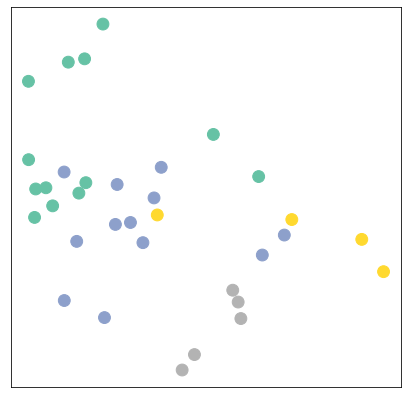

In [ ]:
model = GCN()

out, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

Filtering out training nodes from the labels and classifier outputs by training masks

In [ ]:
data.y[data.train_mask] # labels

tensor([1, 3, 0, 2])

In [ ]:
out[data.train_mask] # cassifier outputs

tensor([[-0.1800,  0.6862,  0.1598,  0.1413],
        [-0.1999,  0.6750,  0.1442,  0.1249],
        [-0.1940,  0.6523,  0.1278,  0.0997],
        [-0.1739,  0.7036,  0.1758,  0.1624]], grad_fn=<IndexBackward0>)

Training phase

<IPython.core.display.Javascript object>

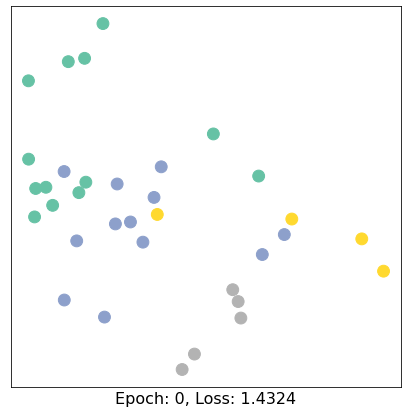

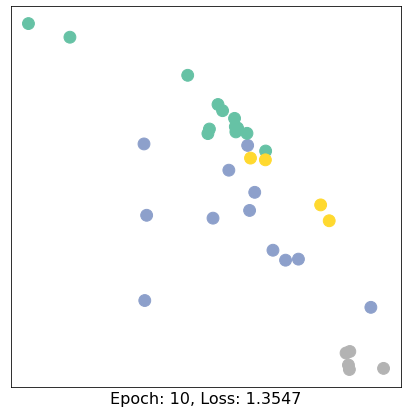

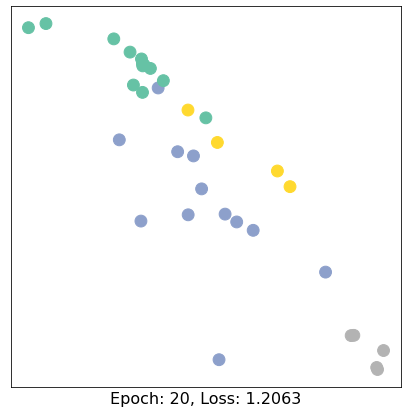

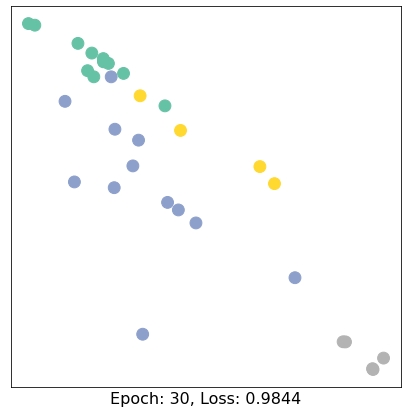

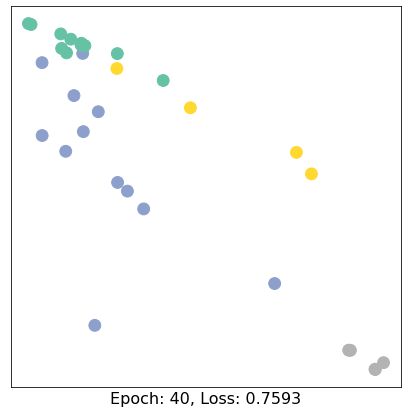

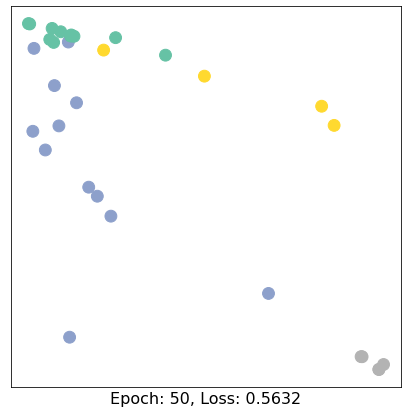

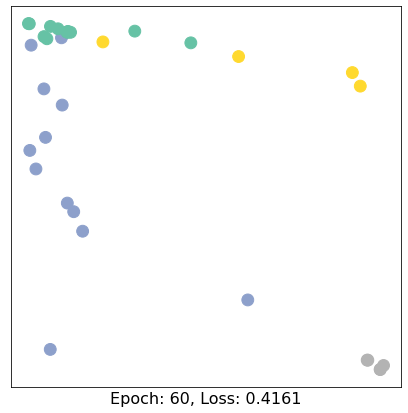

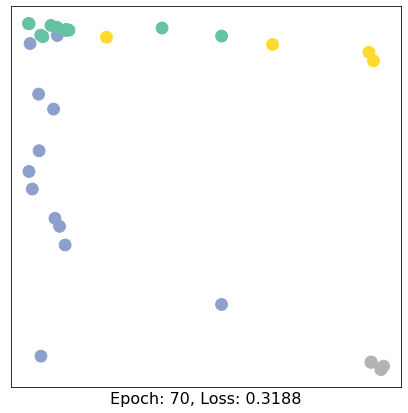

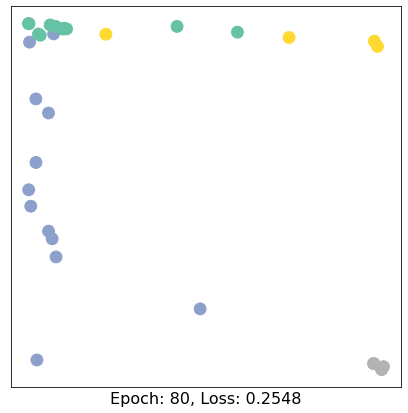

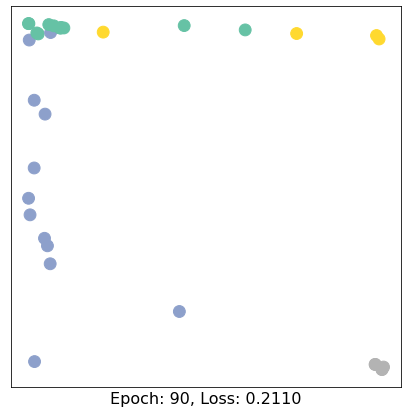

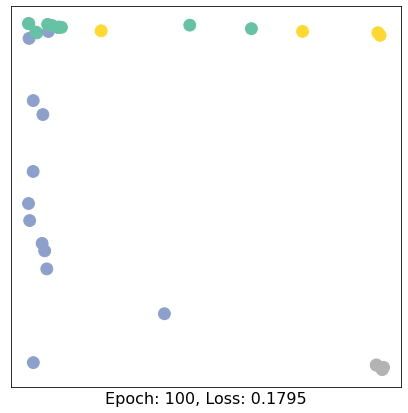

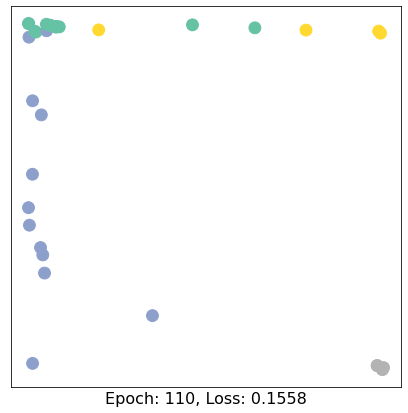

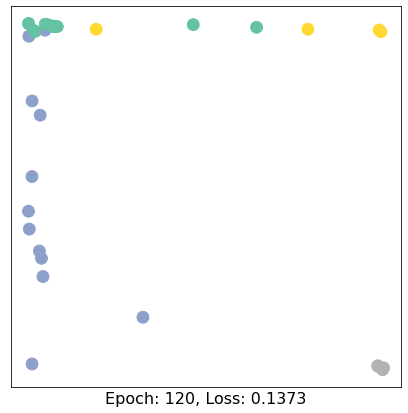

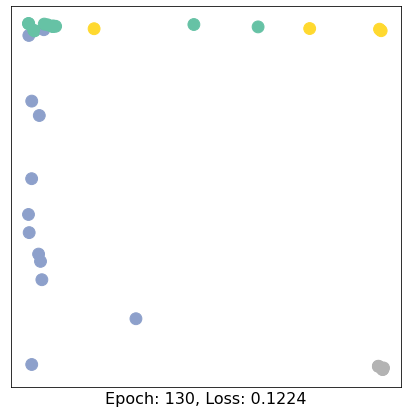

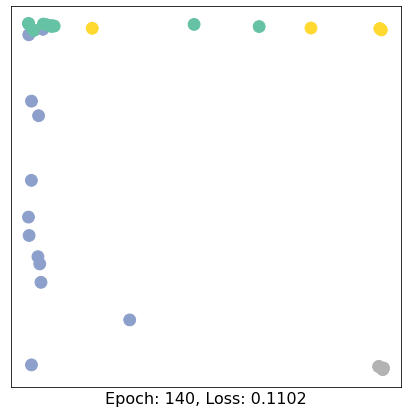

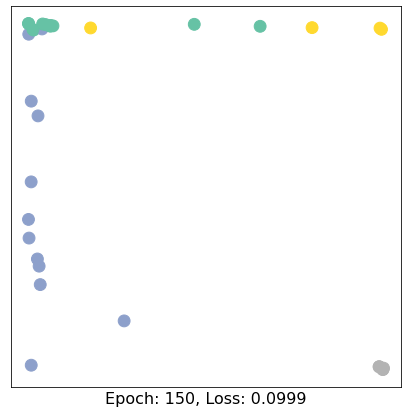

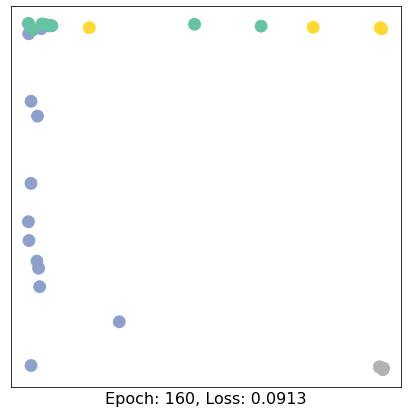

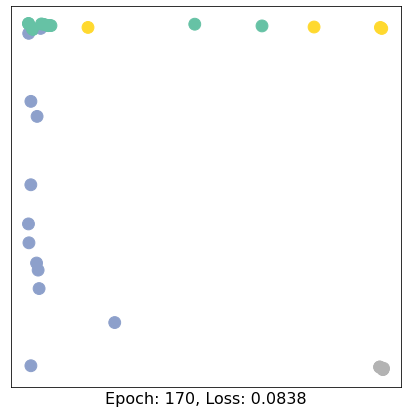

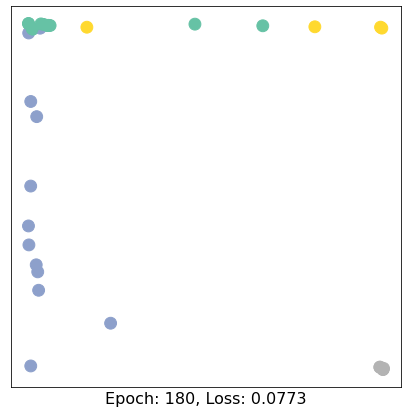

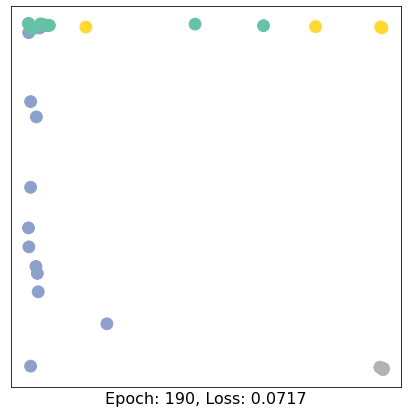

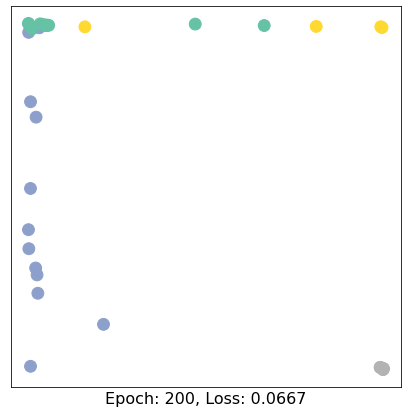

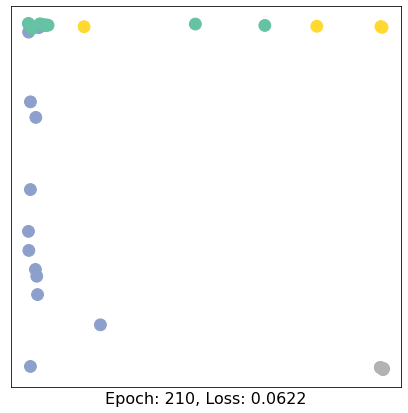

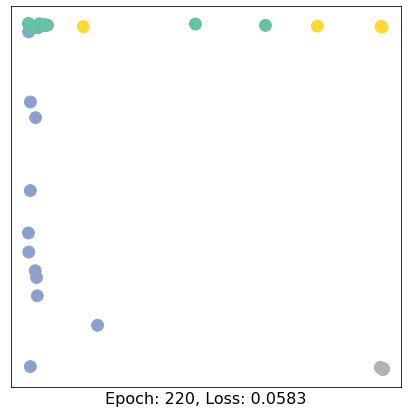

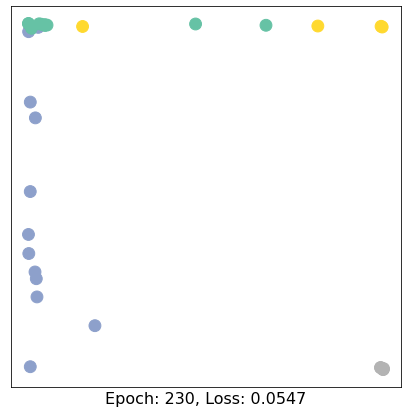

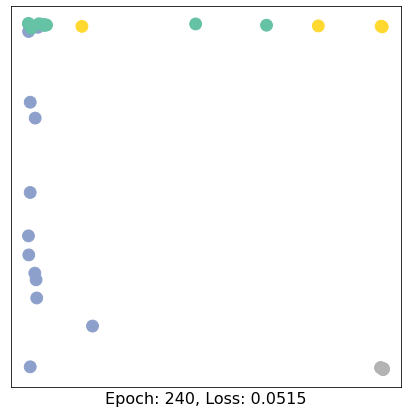

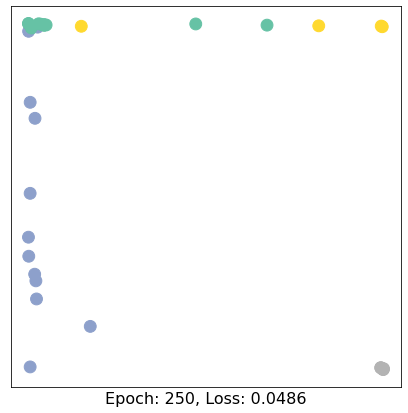

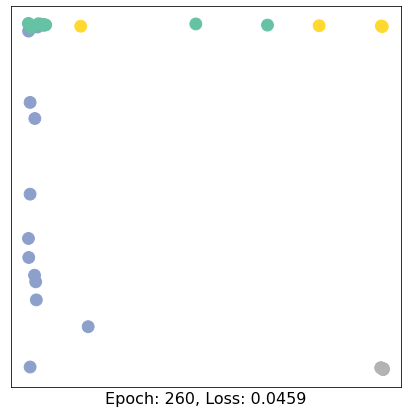

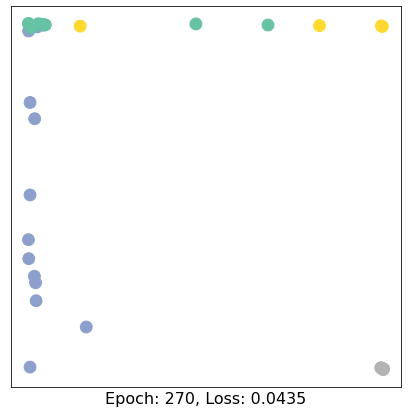

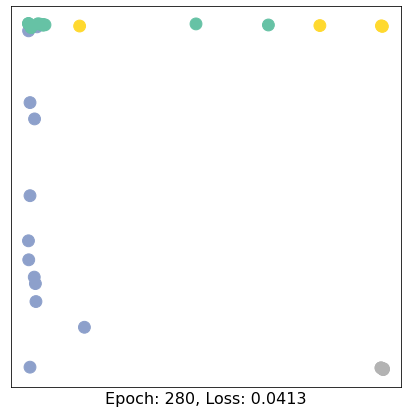

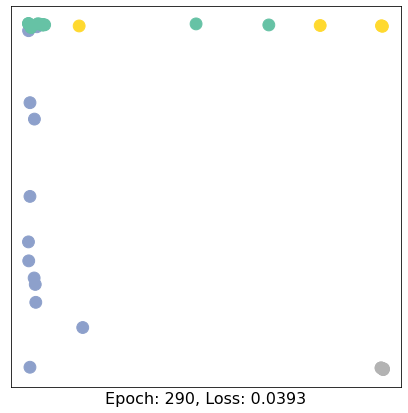

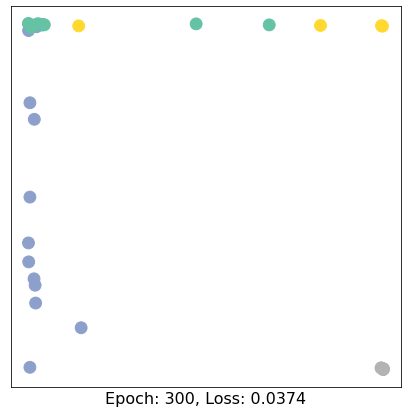

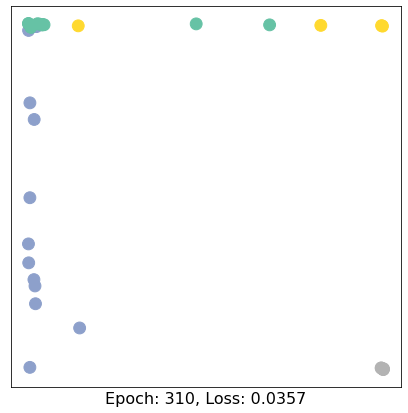

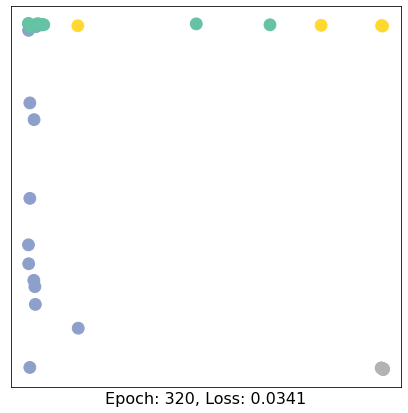

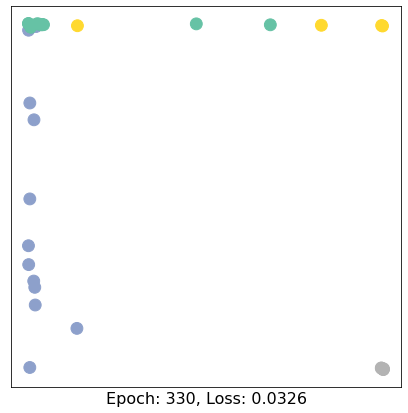

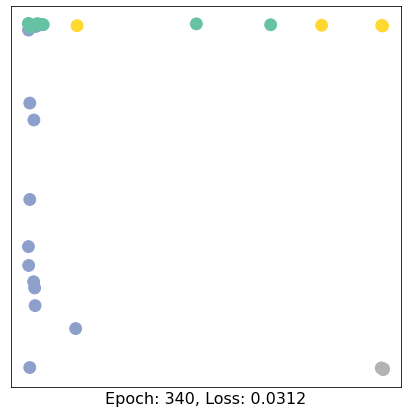

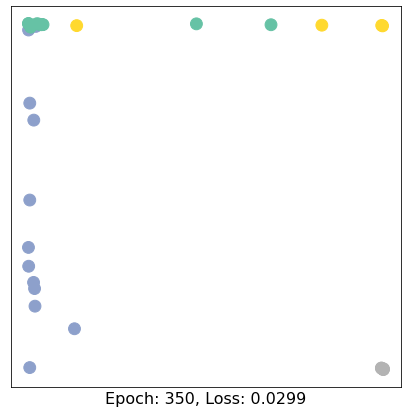

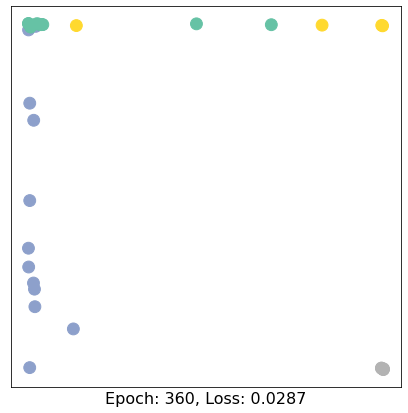

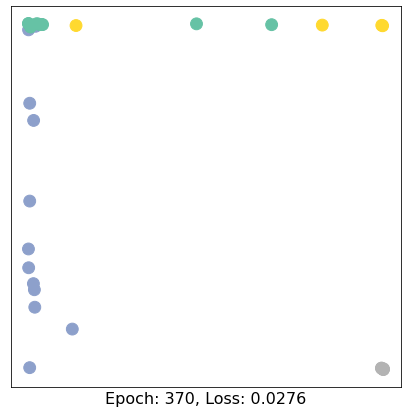

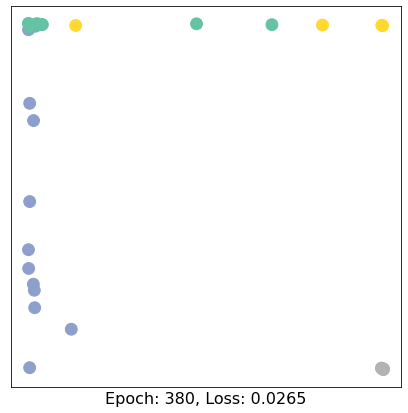

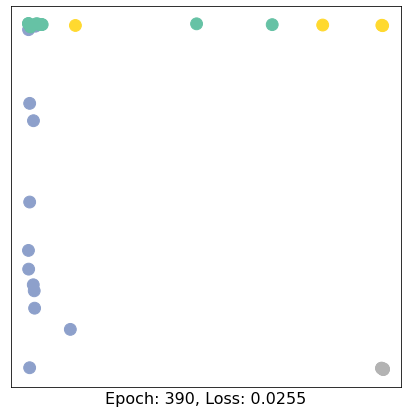

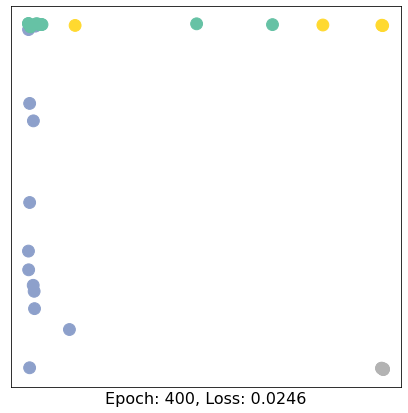

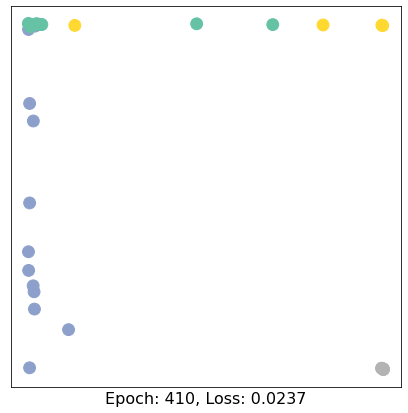

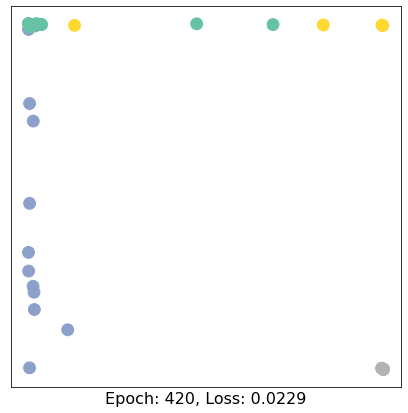

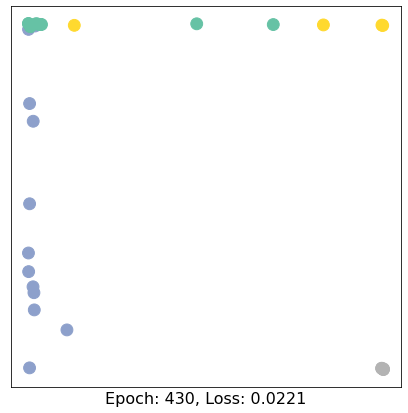

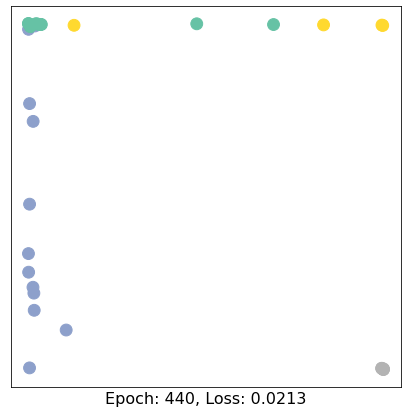

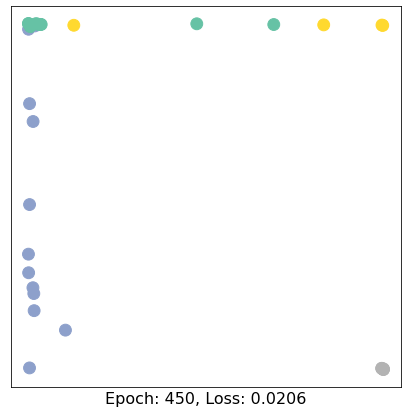

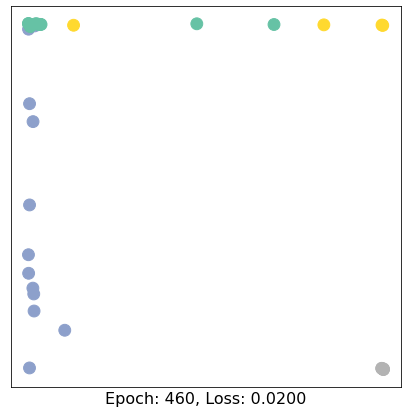

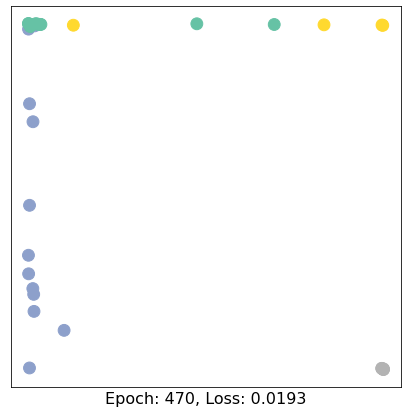

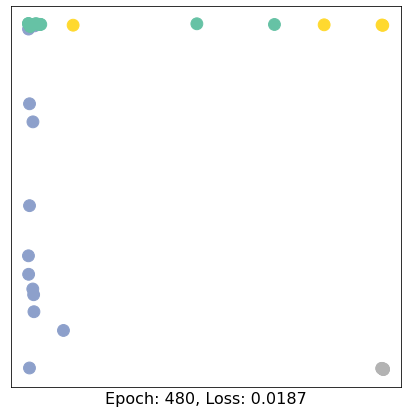

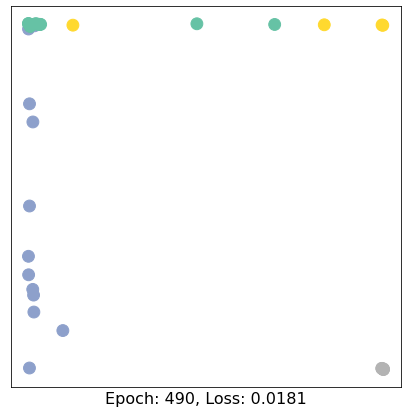

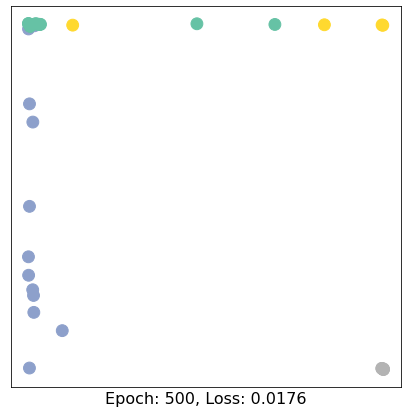

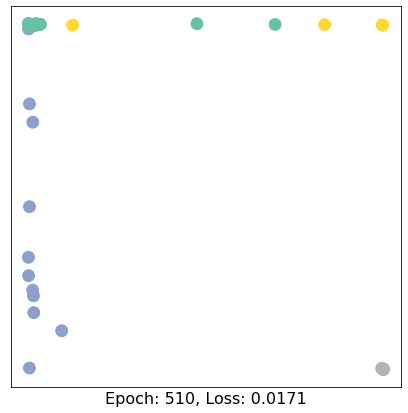

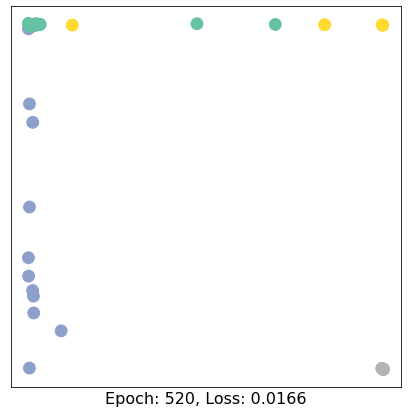

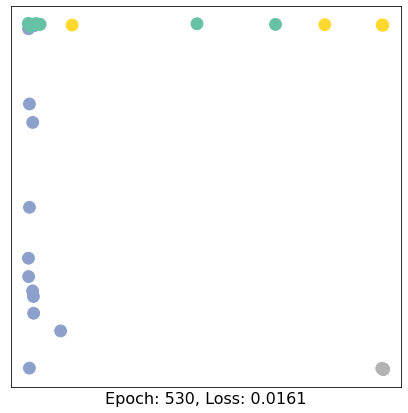

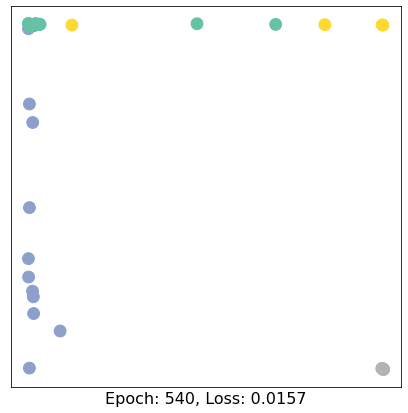

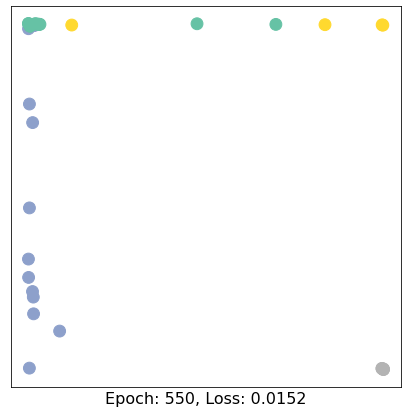

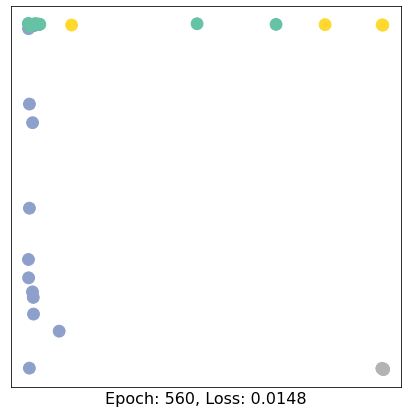

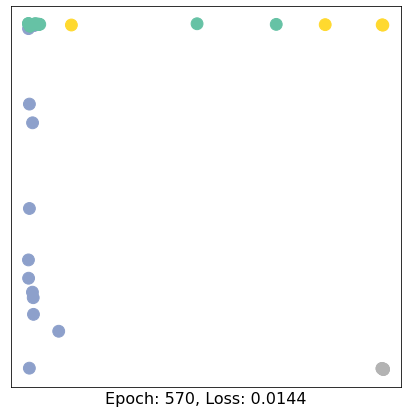

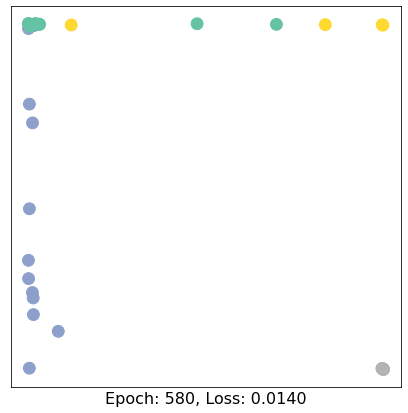

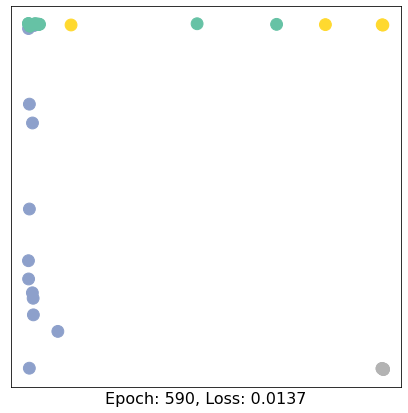

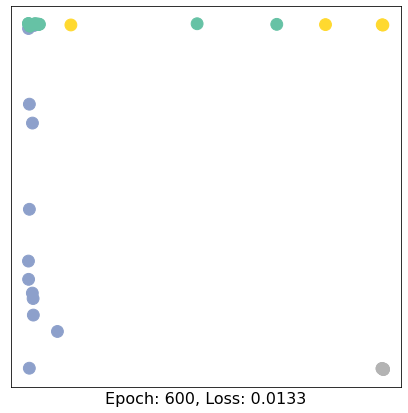

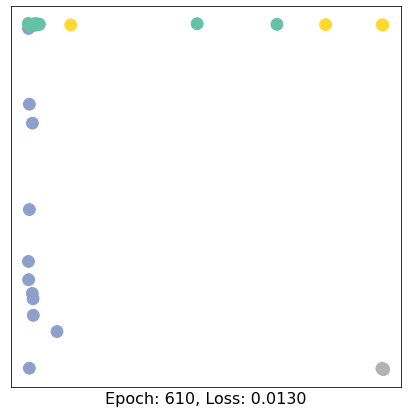

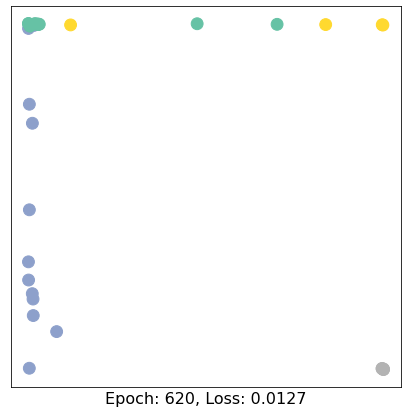

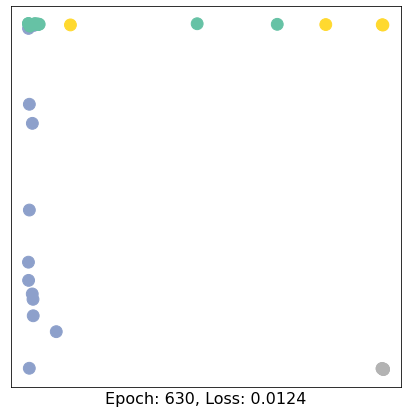

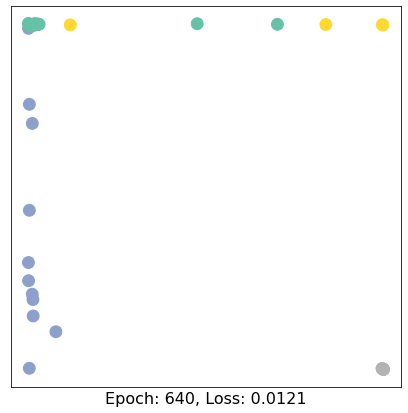

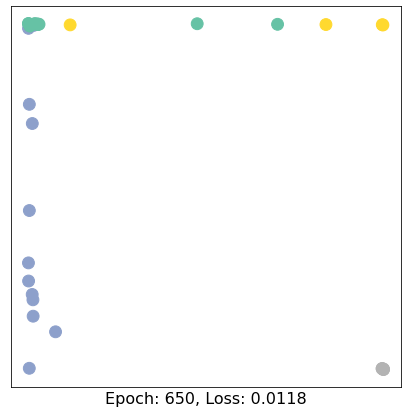

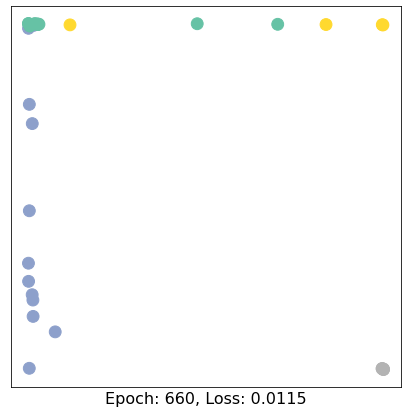

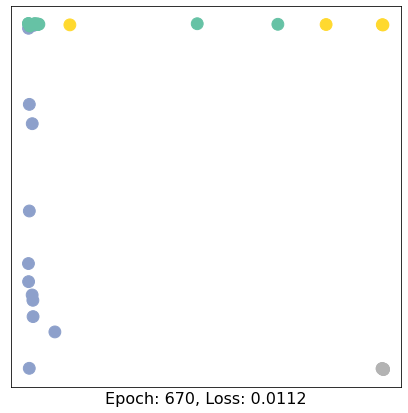

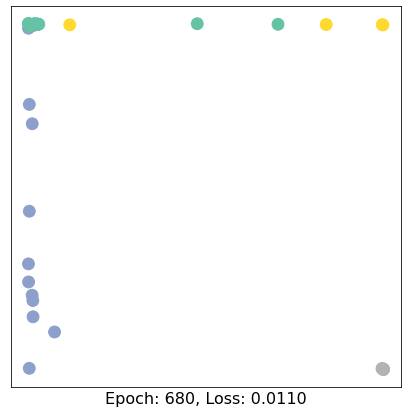

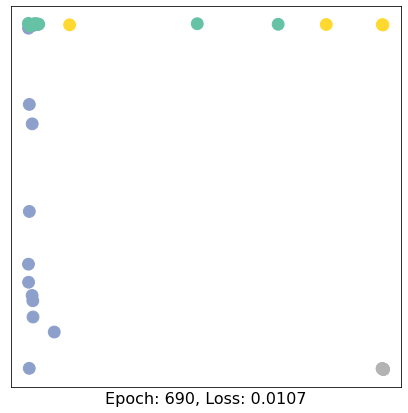

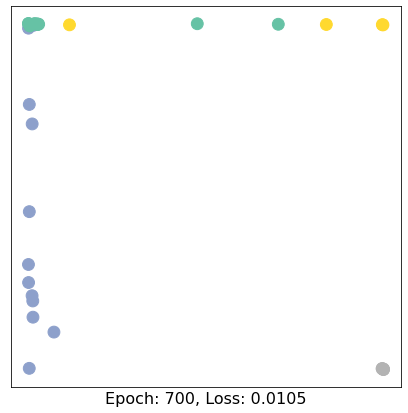

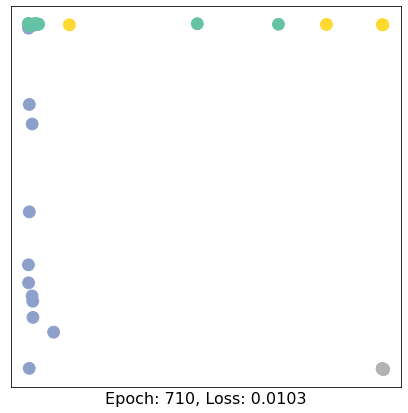

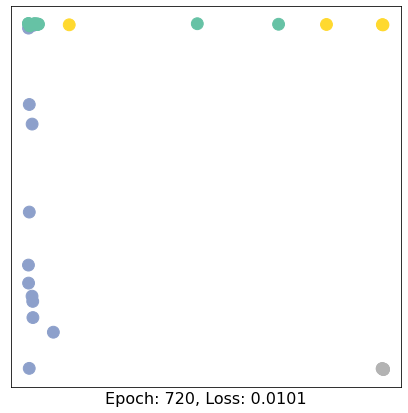

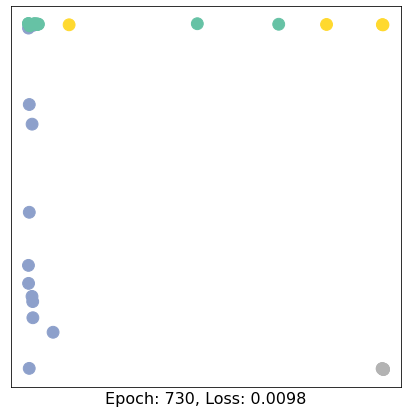

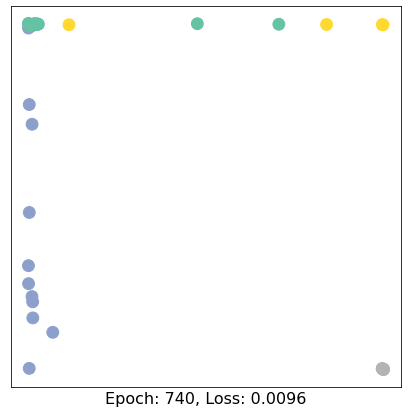

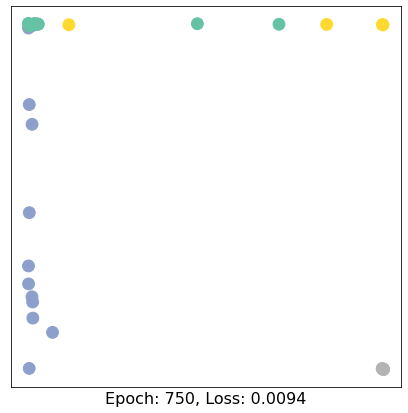

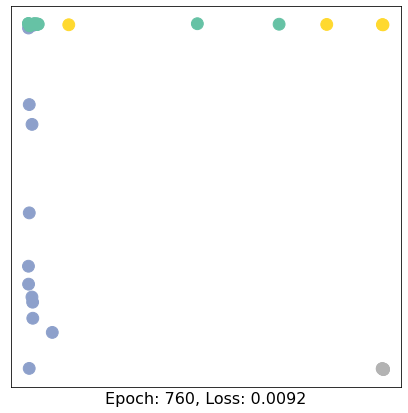

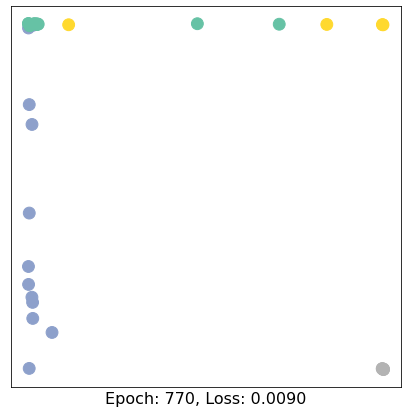

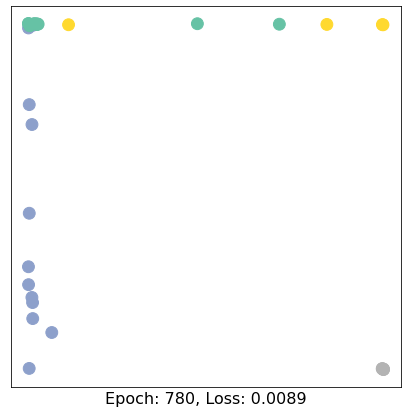

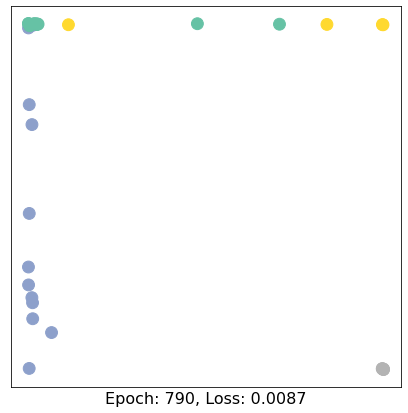

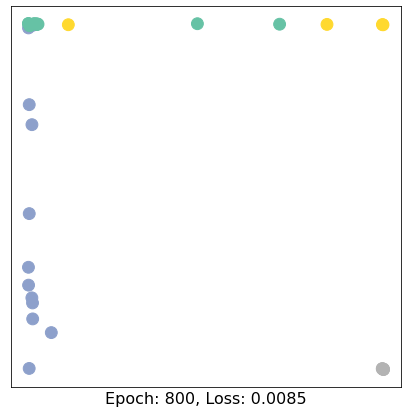

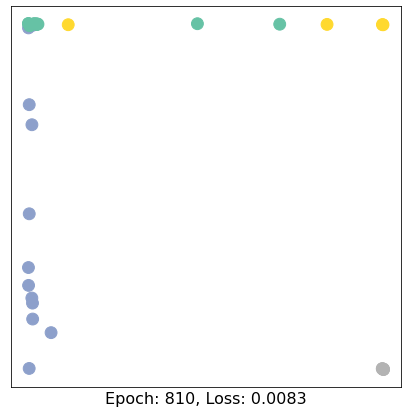

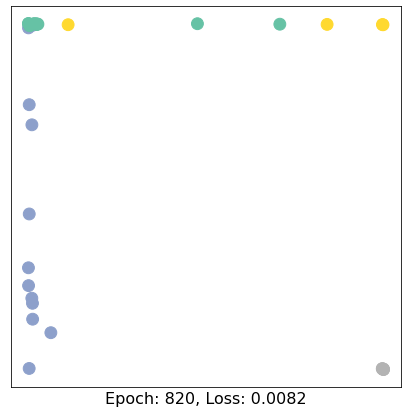

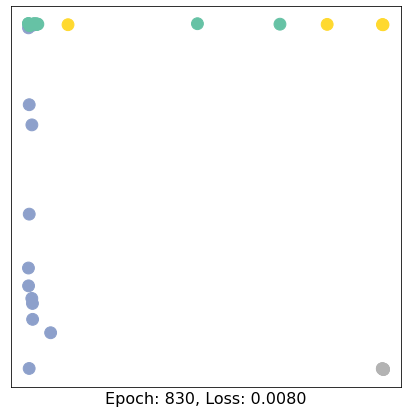

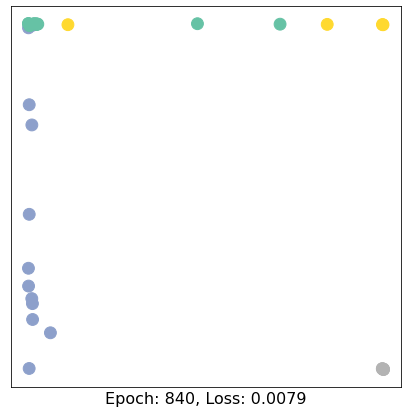

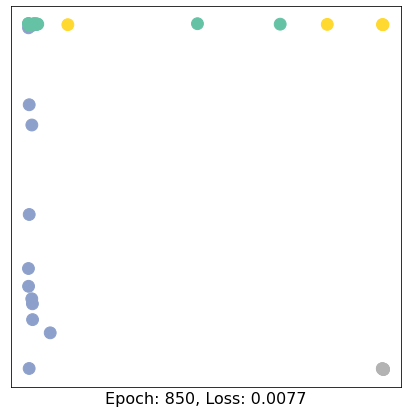

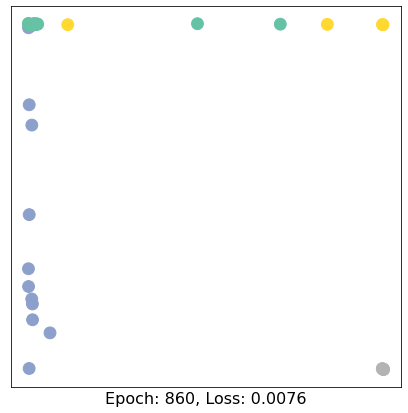

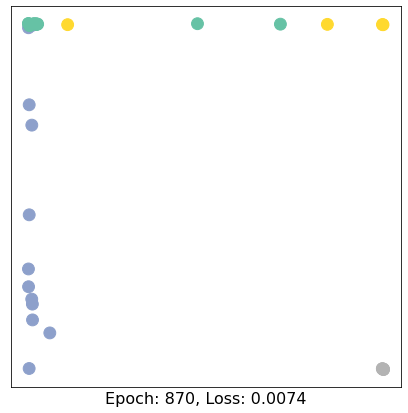

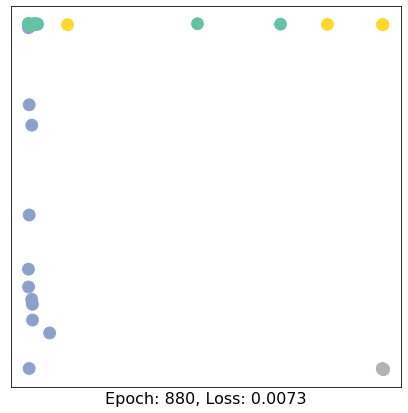

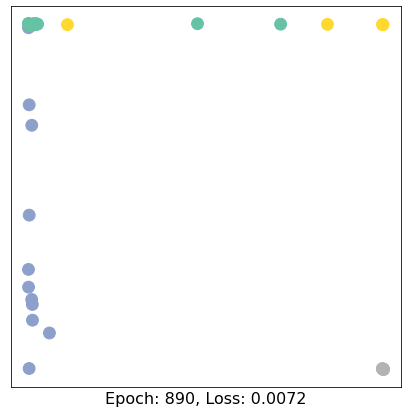

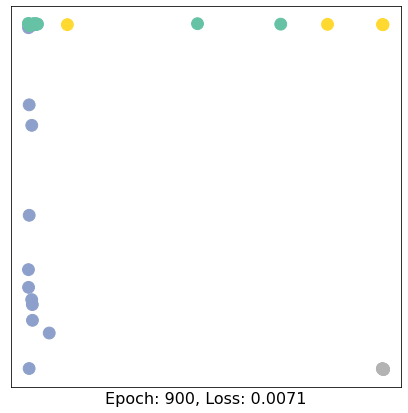

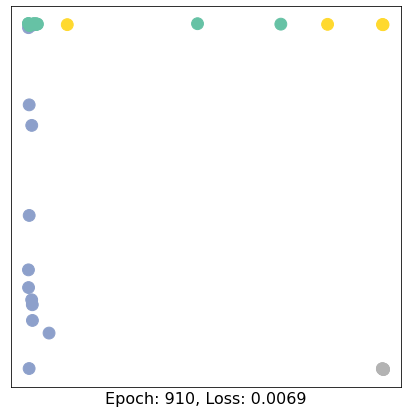

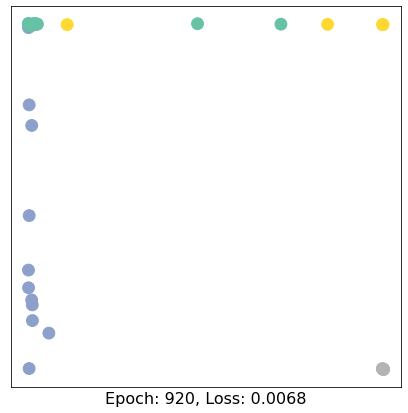

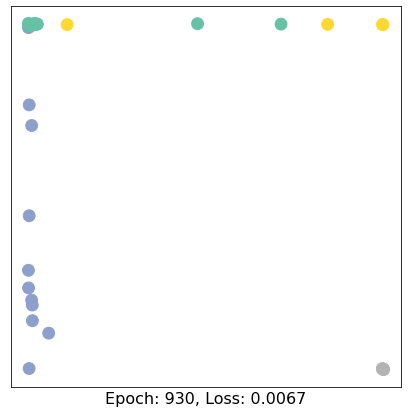

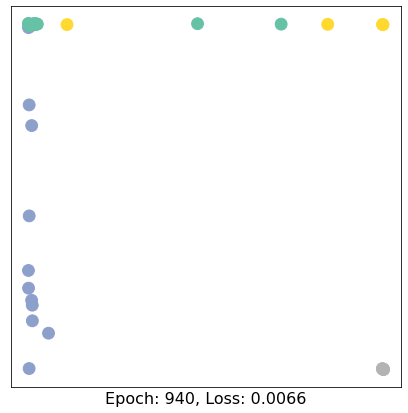

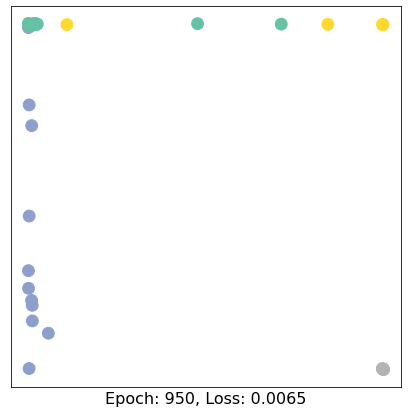

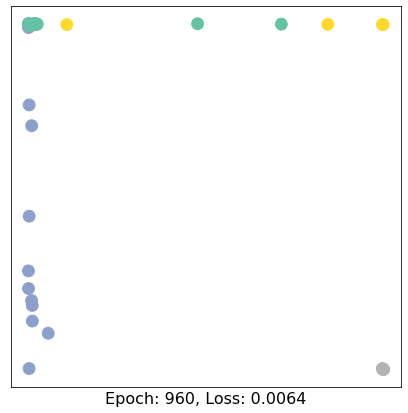

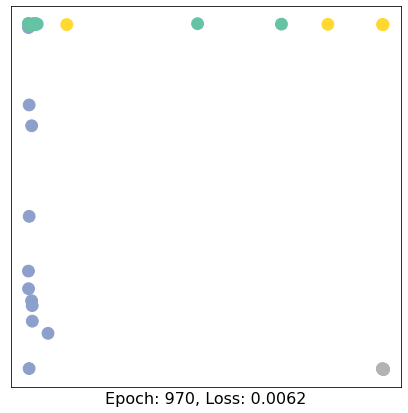

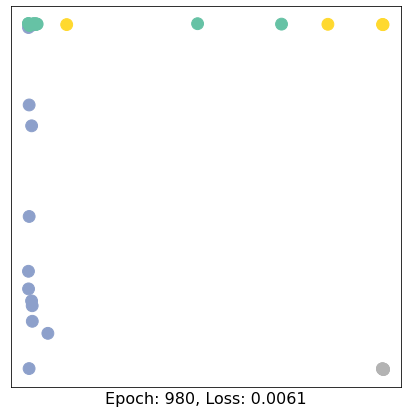

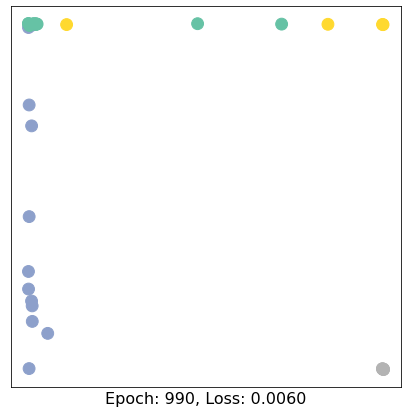

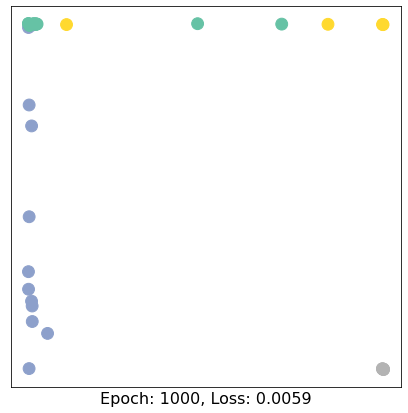

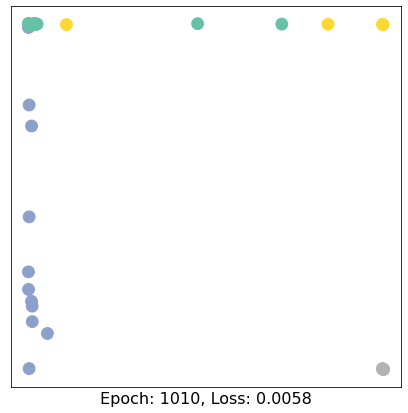

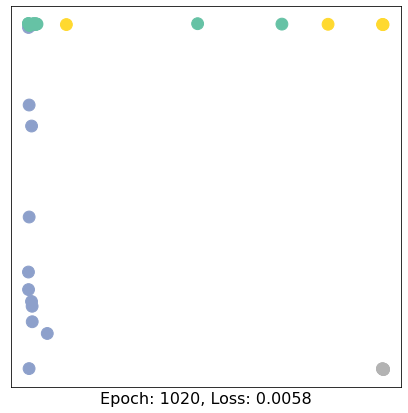

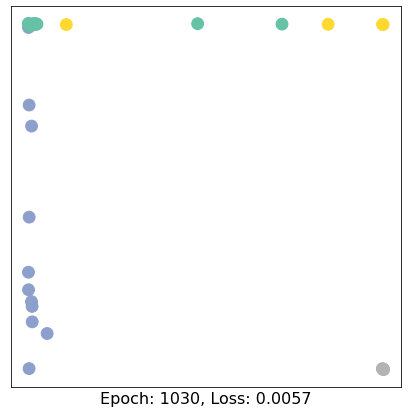

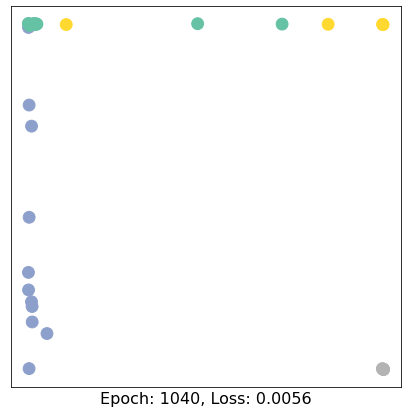

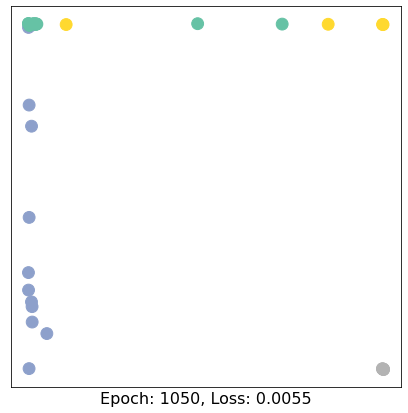

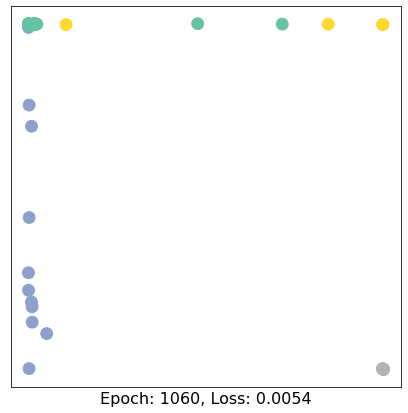

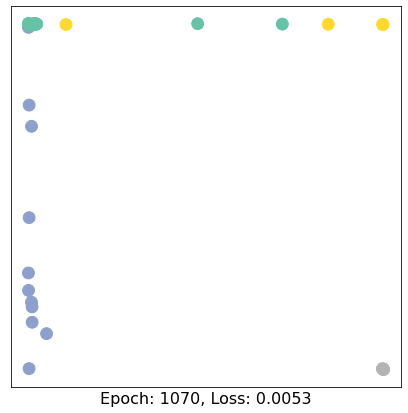

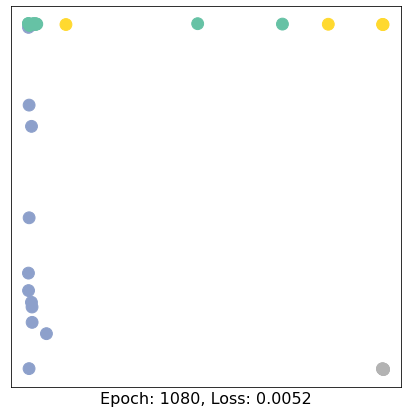

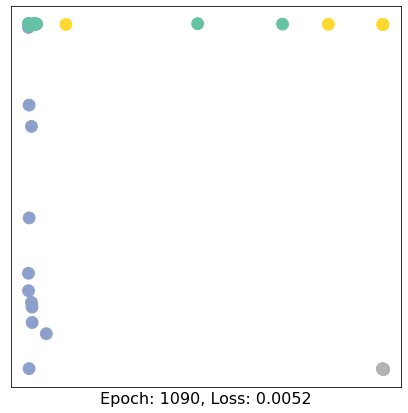

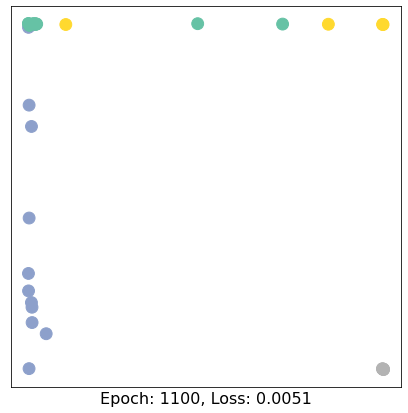

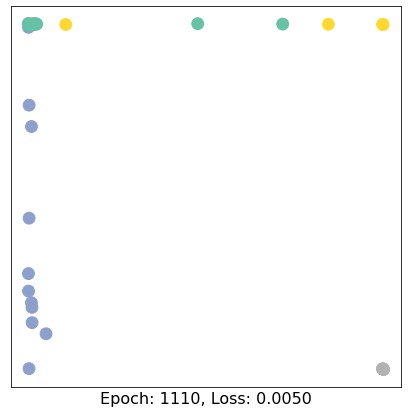

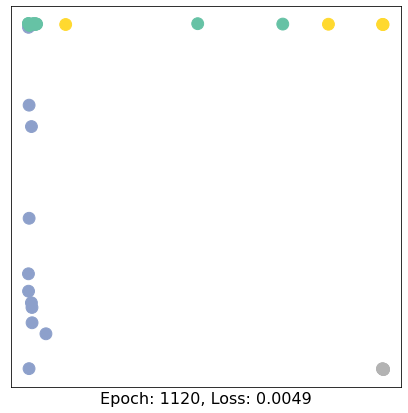

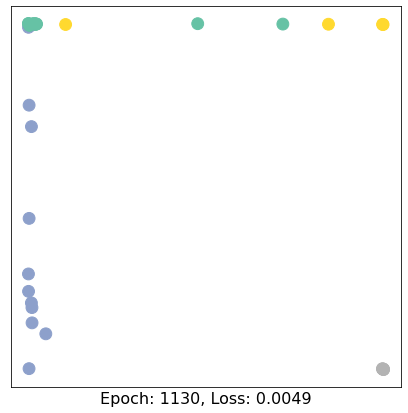

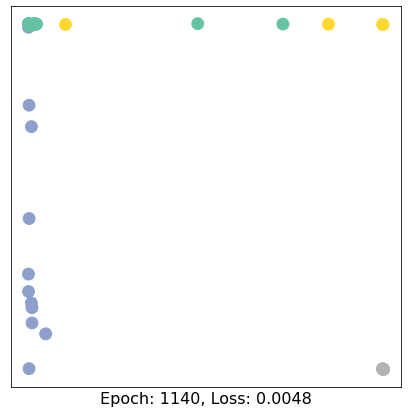

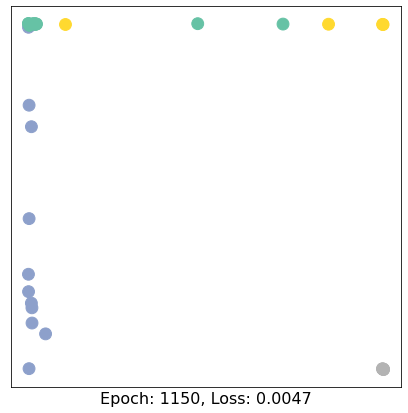

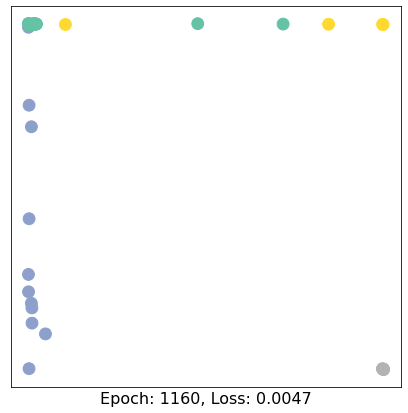

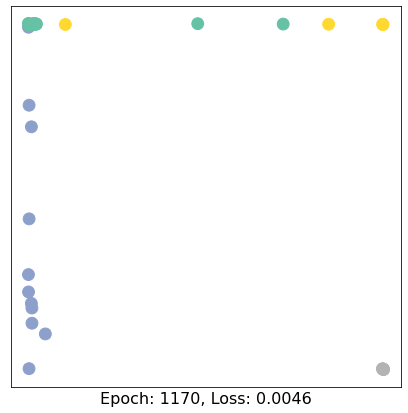

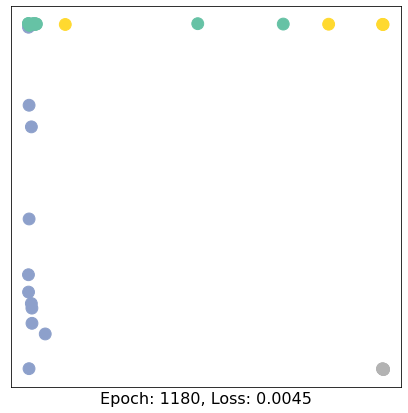

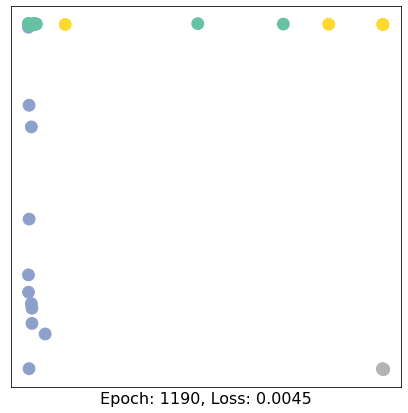

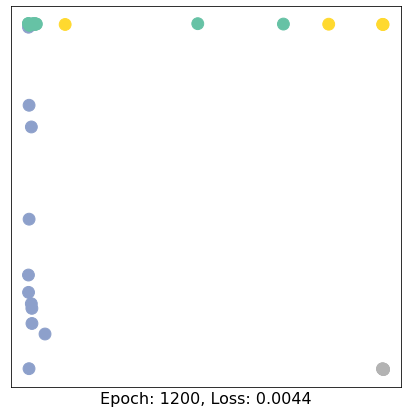

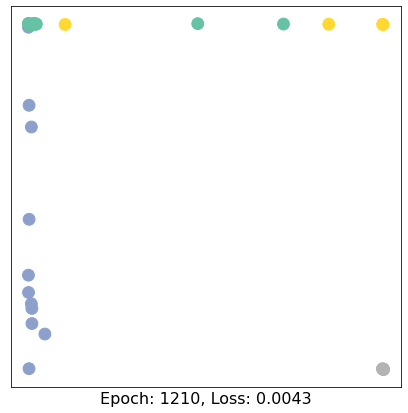

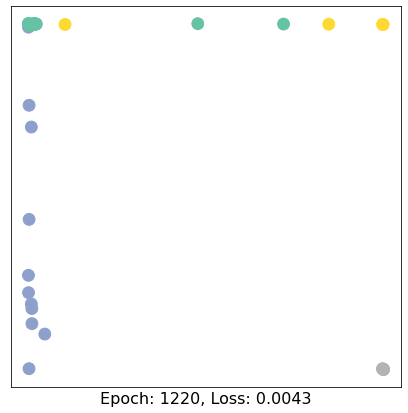

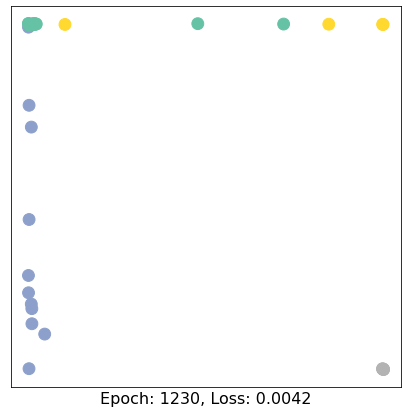

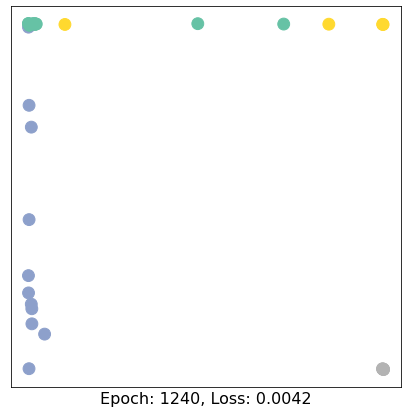

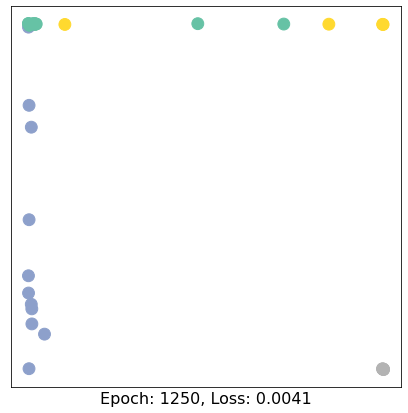

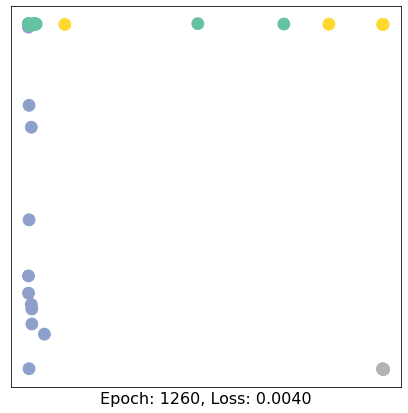

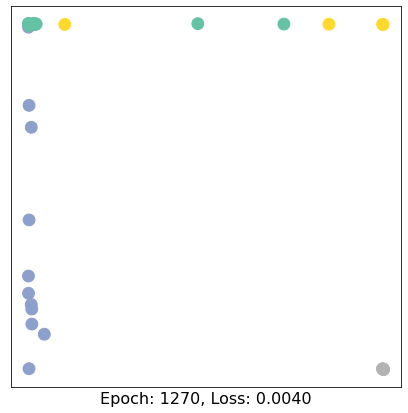

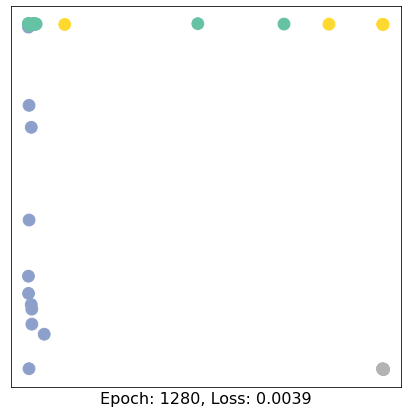

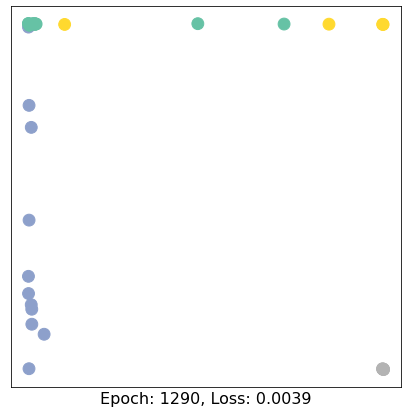

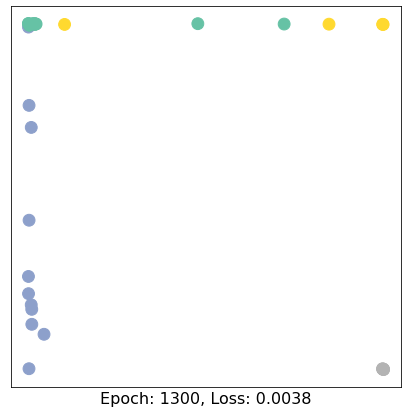

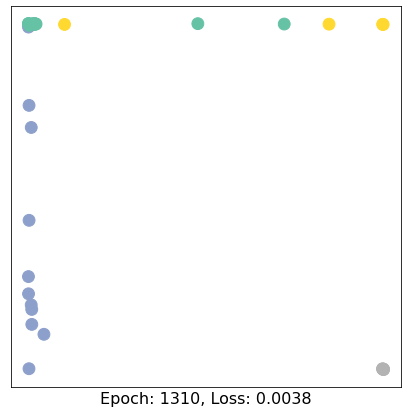

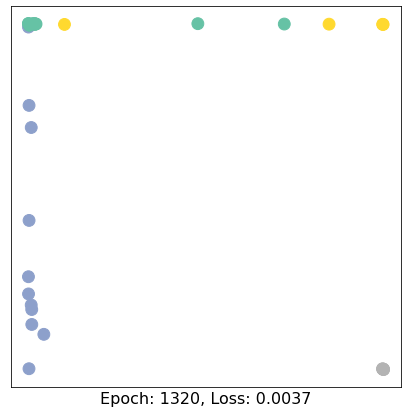

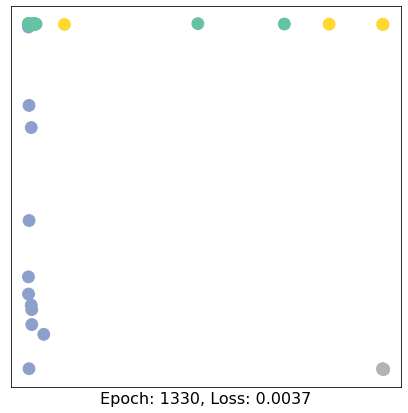

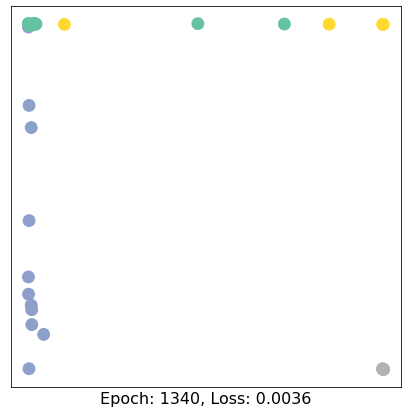

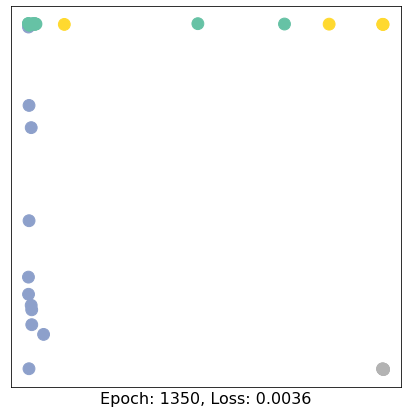

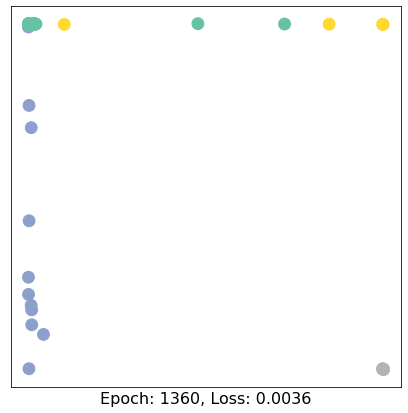

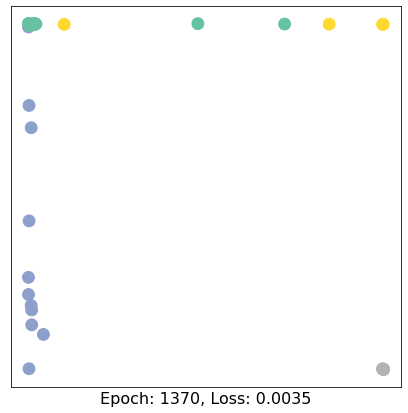

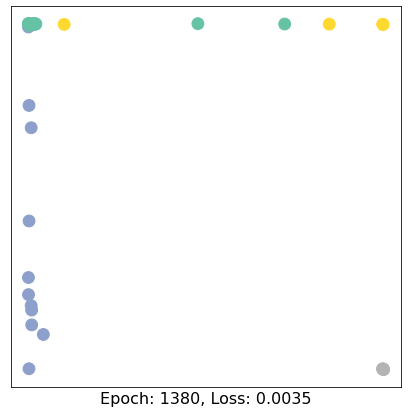

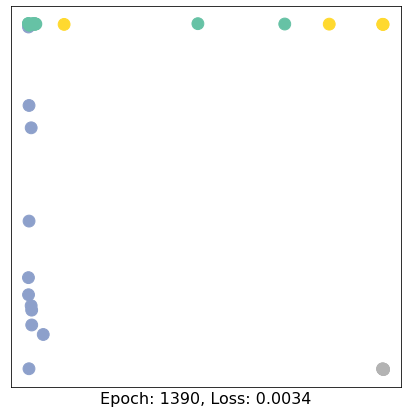

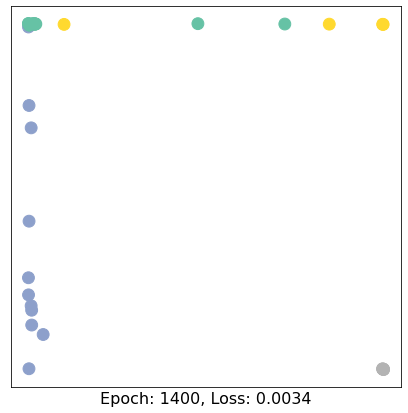

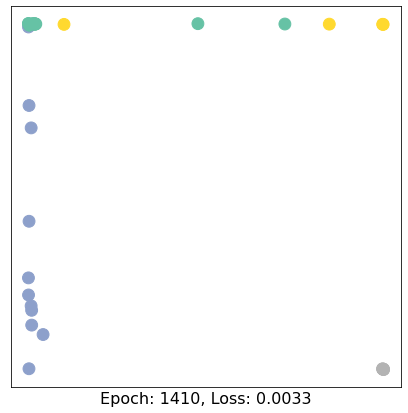

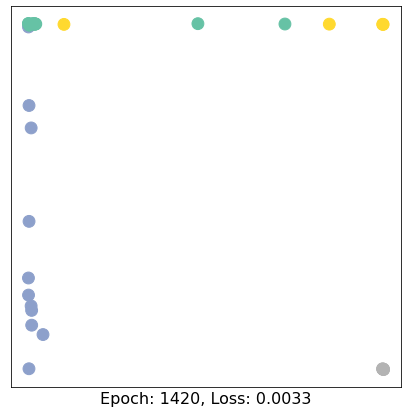

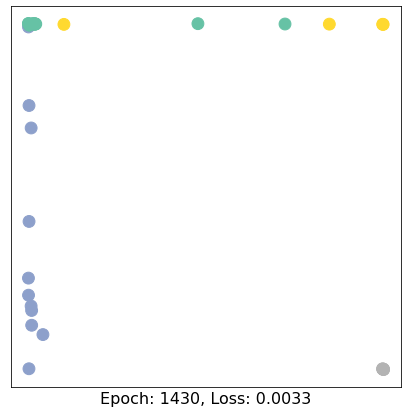

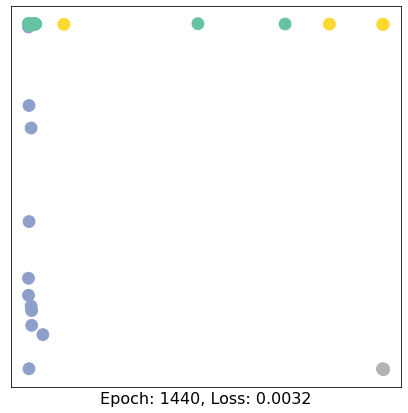

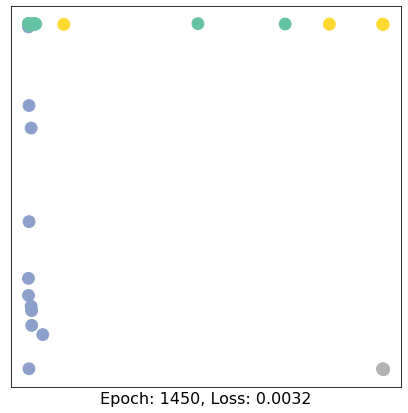

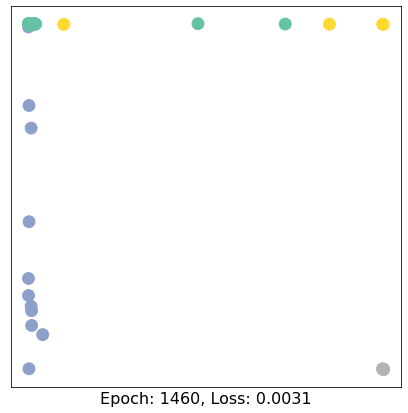

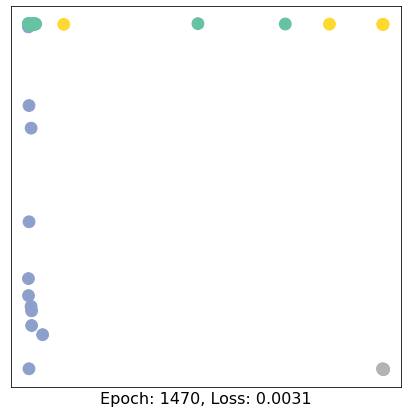

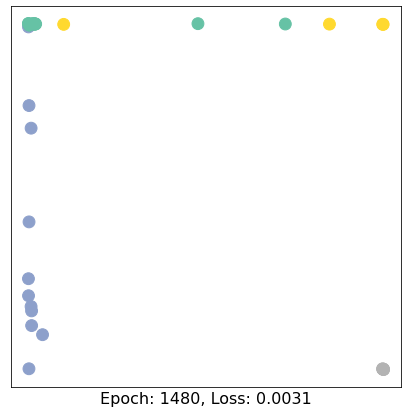

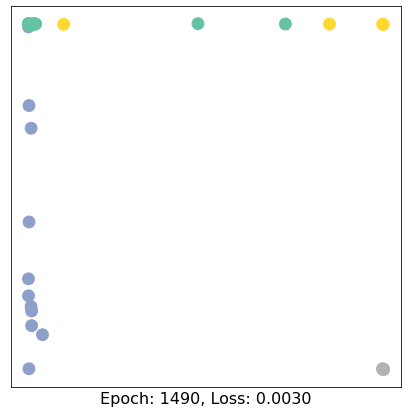

In [ ]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

net = GCN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

def train(data):
  optimizer.zero_grad()
  out, h = net(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return out, h, loss

for epoch in range(1500):
  out, h, loss = train(data)
  if epoch % 10 == 0:
    visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
    time.sleep(0.3)

# Node Classification

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print(f'=====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}') #feature dim of each node
print(f'Number of classes: {dataset.num_classes}') # labels


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [3]:
data = dataset[0]
print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Can a simple MLP solve the classification problem?

In [5]:
import torch
from torch.nn import Linear
from torch import nn
import torch.nn.functional as F

class MLP(torch.nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(12345)
    # self.lin1 = Linear(dataset.num_features, 512)
    # self.lin2 = Linear(512, 256)
    # self.lin3 = Linear(256, 128)
    # self.lin4 = Linear(128, 64)
    # self.lin5 = Linear(64, 16)
    # self.lin6 = Linear(16, dataset.num_classes)

    self.fc = nn.Sequential(
        nn.Linear(dataset.num_features, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(256, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(128, 64),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(64, 16),
        nn.ReLU(inplace=True),
        nn.Linear(16, dataset.num_classes)
    )
  
  def forward(self, x):
    x = self.fc(x)
    return x


In [6]:
net = MLP()
print(net)

MLP(
  (fc): Sequential(
    (0): Linear(in_features=1433, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=64, out_features=16, bias=True)
    (13): ReLU(inplace=True)
    (14): Linear(in_features=16, out_features=7, bias=True)
  )
)


In [7]:
int(data.train_mask.sum())

140

In [8]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

net = MLP()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

def get_accuracy(pred, mask, acc_type):
  correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
  acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
  print(f'{acc_type} Accuracy: {acc:.4f} ', end='')
  # return acc

def train():
  net.train()
  optimizer.zero_grad()
  out = net(data.x)
  
  pred = out.argmax(dim=1)
  get_accuracy(pred, data.train_mask, 'Train')

  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()

  return out, loss

def validation():
  net.eval()
  out = net(data.x)
  
  pred = out.argmax(dim=1)
  get_accuracy(pred, data.val_mask, 'Validation')
  
  loss = criterion(out[data.val_mask], data.y[data.val_mask])
  
  return out, loss

def test():
  net.eval()
  out = net(data.x)
  pred = out.argmax(dim=1)
  get_accuracy(pred, data.test_mask, 'Test')


<IPython.core.display.Javascript object>

In [9]:
for epoch in range(1, 201):
    _, loss = train()
    print(f'Epoch: {epoch:03d}, Training Loss: {loss:.4f}\n')

    _, loss = validation()
    print(f'Epoch: {epoch:03d}, Validation Loss: {loss:.4f}\n')
    print('='*20)


Train Accuracy: 0.1429 Epoch: 001, Training Loss: 1.9623

Validation Accuracy: 0.1220 Epoch: 001, Validation Loss: 2.0121

Train Accuracy: 0.1429 Epoch: 002, Training Loss: 1.9597

Validation Accuracy: 0.1220 Epoch: 002, Validation Loss: 2.0031

Train Accuracy: 0.1429 Epoch: 003, Training Loss: 1.9575

Validation Accuracy: 0.1220 Epoch: 003, Validation Loss: 1.9940

Train Accuracy: 0.1429 Epoch: 004, Training Loss: 1.9534

Validation Accuracy: 0.1220 Epoch: 004, Validation Loss: 1.9839

Train Accuracy: 0.1429 Epoch: 005, Training Loss: 1.9451

Validation Accuracy: 0.1380 Epoch: 005, Validation Loss: 1.9661

Train Accuracy: 0.1643 Epoch: 006, Training Loss: 1.9255

Validation Accuracy: 0.0720 Epoch: 006, Validation Loss: 1.9402

Train Accuracy: 0.1571 Epoch: 007, Training Loss: 1.8777

Validation Accuracy: 0.0860 Epoch: 007, Validation Loss: 1.9032

Train Accuracy: 0.1571 Epoch: 008, Training Loss: 1.7968

Validation Accuracy: 0.0860 Epoch: 008, Validation Loss: 1.8835

Train Accuracy: 

In [10]:
test()

Test Accuracy: 0.3770 

Small Test accuracy and overfits at the very start, since there are small number of training nodes. Does not incorporate the bias that citated papers are connected to the category of the document. So GNN can be used here.

In [11]:
from torch_geometric.nn import GCNConv

class GCN_node_class(torch.nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    torch.manual_seed(123)
    self.gcn_conv1 = GCNConv(dataset.num_features, hidden_channels)
    self.gcn_conv2 = GCNConv(hidden_channels, dataset.num_classes)
  
  def forward(self, x, edge_index):
    x = self.gcn_conv1(x, edge_index)
    x = x.relu()
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.gcn_conv2(x, edge_index)
    return x

In [12]:
gcn = GCN_node_class(16)
print(gcn)

GCN_node_class(
  (gcn_conv1): GCNConv(1433, 16)
  (gcn_conv2): GCNConv(16, 7)
)


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


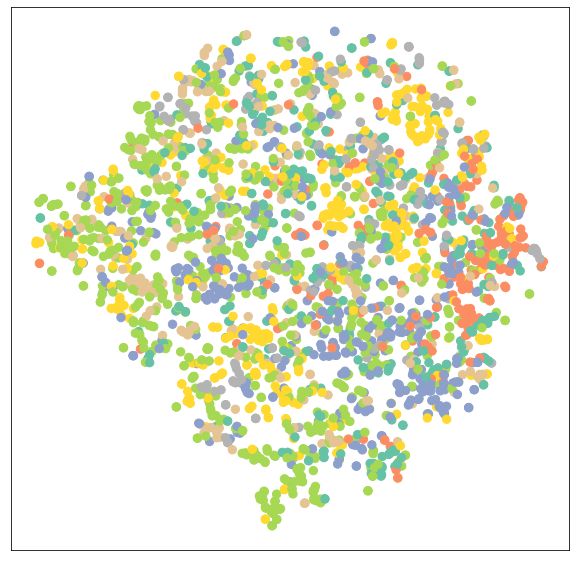

In [28]:
gcn.eval()
out = gcn(data.x, data.edge_index)
visualize(out, color=data.y)

In [39]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


def train(model):
  # print('In Train')
  # print(model)
  model.train()
  optimizer.zero_grad()
  out = model(data.x, data.edge_index)

  pred = out.argmax(dim=1)
  get_accuracy(pred, data.val_mask, 'Train')

  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()

  return out, loss

def validation(model):
  model.eval()
  out = model(data.x, data.edge_index)
  
  pred = out.argmax(dim=1)
  get_accuracy(pred, data.val_mask, 'Validation')
  
  loss = criterion(out[data.val_mask], data.y[data.val_mask])
  
  return out, loss

def test(model):
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1)
  get_accuracy(pred, data.test_mask, 'Test')


<IPython.core.display.Javascript object>

In [54]:
def train_model(model):
  # print('In train_model()')
  # print(model)
  min_valid_loss = 10000000
  for epoch in range(1000):
      _, train_loss = train(model)
      _, validation_loss = validation(model)

      print('\n')
      print(f'Epoch: {epoch:03d}, Training Loss: {train_loss:.4f}  ', end='')
      print(f'Epoch: {epoch:03d}, Validation Loss: {validation_loss:.4f}\n')
      print('='*20)

      if min_valid_loss > validation_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f} ---> {validation_loss:.6f}) \t Saving The Model')
        min_valid_loss = validation_loss

        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')

In [50]:
def test_model(model, model_class, saved_path, initial_hidden_channels):
  model = model_class(initial_hidden_channels)
  model.load_state_dict(torch.load(saved_path))
  model.eval()
  test(model)

In [63]:
test()

Test Accuracy: 0.8140 

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


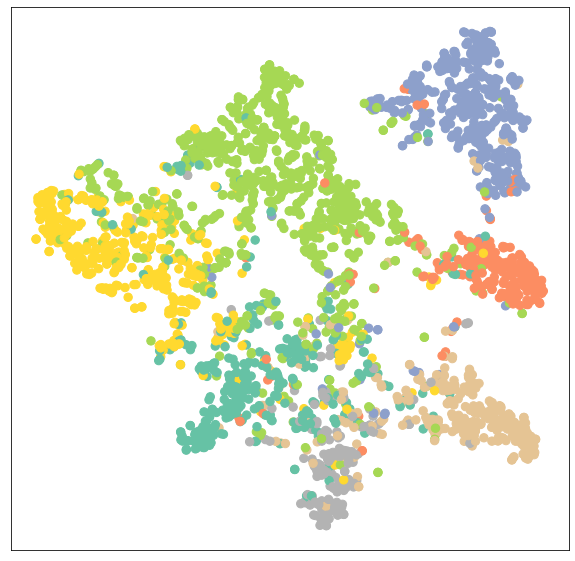

In [43]:
net.eval()

out = net(data.x, data.edge_index)
visualize(out, color=data.y)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


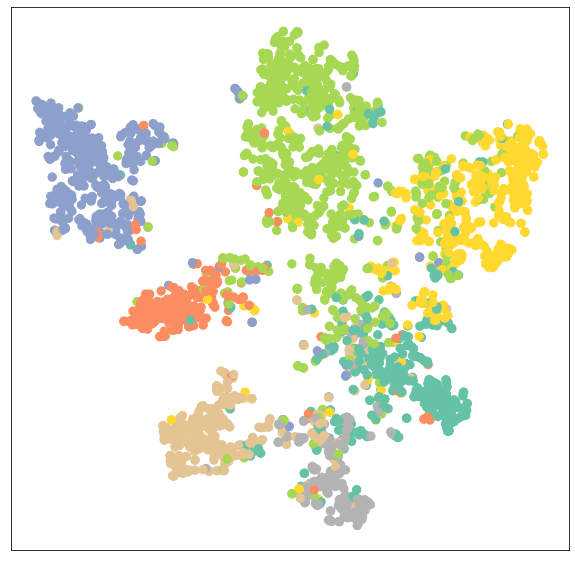

In [64]:
net.eval()

out = net(data.x, data.edge_index)
visualize(out, color=data.y)

In [44]:
from torch_geometric.nn import GCNConv


class GCN_node_class_deeper(torch.nn.Module):
  def __init__(self, initial_hidden_channels):
    super().__init__()
    torch.manual_seed(123)
    self.gcn_conv1 = GCNConv(dataset.num_features, initial_hidden_channels)
    self.gcn_conv2 = GCNConv(initial_hidden_channels, 128)
    self.gcn_conv3 = GCNConv(128, 64)
    self.gcn_conv4 = GCNConv(64, dataset.num_classes)
  
  def forward(self, x, edge_index):
    x = self.gcn_conv1(x, edge_index)
    x = x.relu()
    F.dropout(x, p=0.3, training=self.training)

    x = self.gcn_conv2(x, edge_index)
    x = x.relu()
    F.dropout(x, p=0.3, training=self.training)

    x = self.gcn_conv3(x, edge_index)
    x = x.relu()
    F.dropout(x, p=0.2, training=self.training)

    x = self.gcn_conv4(x, edge_index)

    return x

# class GCN(torch.nn.Module):
#     def __init__(self, hidden_channels):
#         super().__init__()
#         self.conv1 = GCNConv(dataset.num_features, hidden_channels)
#         # self.conv2 = GCNConv(hidden_channels, 64)
#         self.conv3 = GCNConv(hidden_channels, dataset.num_classes)

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index)
#         x = x.relu()
#         x = F.dropout(x, p=0.5, training=self.training)
#         # x = self.conv2(x, edge_index)
#         # x = x.relu()
#         # x = F.dropout(x, p=0.5, training=self.training)
#         x = self.conv3(x, edge_index)
#         return x

In [55]:
model_deeper = GCN_node_class_deeper(256)
optimizer = torch.optim.Adam(model_deeper.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
print(model_deeper)

GCN_node_class_deeper(
  (gcn_conv1): GCNConv(1433, 256)
  (gcn_conv2): GCNConv(256, 128)
  (gcn_conv3): GCNConv(128, 64)
  (gcn_conv4): GCNConv(64, 7)
)


In [56]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

train_model(model_deeper)

<IPython.core.display.Javascript object>

Streaming output truncated to the last 5000 lines.
Epoch: 003, Training Loss: 1.9077  Epoch: 003, Validation Loss: 1.9111

Validation Loss Decreased(1.926806 ---> 1.911102) 	 Saving The Model
Train Accuracy: 0.1740 Validation Accuracy: 0.2340 

Epoch: 004, Training Loss: 1.8674  Epoch: 004, Validation Loss: 1.8815

Validation Loss Decreased(1.911102 ---> 1.881511) 	 Saving The Model
Train Accuracy: 0.2340 Validation Accuracy: 0.3600 

Epoch: 005, Training Loss: 1.7995  Epoch: 005, Validation Loss: 1.7935

Validation Loss Decreased(1.881511 ---> 1.793513) 	 Saving The Model
Train Accuracy: 0.3600 Validation Accuracy: 0.3260 

Epoch: 006, Training Loss: 1.6937  Epoch: 006, Validation Loss: 1.7331

Validation Loss Decreased(1.793513 ---> 1.733061) 	 Saving The Model
Train Accuracy: 0.3260 Validation Accuracy: 0.4480 

Epoch: 007, Training Loss: 1.5473  Epoch: 007, Validation Loss: 1.5652

Validation Loss Decreased(1.733061 ---> 1.565186) 	 Saving The Model
Train Accuracy: 0.4480 Validatio

In [57]:
test_model(model_deeper, GCN_node_class_deeper, '/content/saved_model.pth', 256)

Test Accuracy: 0.7850 